In [1]:
import os

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau

import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.0.0'

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
base_dir = 'cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

IMG_WIDTH = 160
IMG_HEIGHT = 160
BATCH_SIZE = 64
EPOCHS= 100

In [5]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))

total training cat images: 1000
total training dog images: 1000


In [6]:
#generate training data with augmentation
train_datagen = ImageDataGenerator( rotation_range=15,
                                    rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1)

valid_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='binary')

validation_generator = valid_datagen.flow_from_directory(
        validation_dir,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
train_generator.__len__()

32

In [9]:
def build_model(name):
    inputs = keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    x = layers.Conv2D(64, (5, 5), padding='same', activation='relu')(inputs)
    x = layers.MaxPool2D(pool_size=3,strides=2,padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(64, (5, 5), padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=3,strides=2,padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(384, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs, name=name)
    model.summary()
    
    return model

In [10]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_binary_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [11]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
#optimizer = keras.optimizers.Adam()

In [12]:
model_dir = 'lab_logs_datagen/modelsAdam/'
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

In [13]:
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/checkpoint.h5',
                                            monitor='val_binary_accuracy',
                                            save_best_only=True,
                                            mode='max')

In [14]:
model = build_model('model')
model.compile( optimizer = optimizer,
               loss=keras.losses.BinaryCrossentropy(),
               metrics=[keras.metrics.BinaryAccuracy()])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 160, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 80, 80, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 40, 64)        256   

In [15]:
history = model.fit_generator(
                              train_generator,
                              steps_per_epoch=BATCH_SIZE,
                              callbacks=[learning_rate_reduction, model_mckp],
                              epochs=EPOCHS,
                              validation_data=validation_generator,
                              validation_steps=BATCH_SIZE)

Epoch 1/100
64/64 [==============================] - 83s 1s/step - loss: 3.6721 - binary_accuracy: 0.5370 - val_loss: 0.7171 - val_binary_accuracy: 0.5280
Epoch 2/100
64/64 [==============================] - 39s 602ms/step - loss: 1.2080 - binary_accuracy: 0.5433 - val_loss: 0.6934 - val_binary_accuracy: 0.5330
Epoch 3/100
64/64 [==============================] - 38s 586ms/step - loss: 0.8844 - binary_accuracy: 0.5355 - val_loss: 0.7330 - val_binary_accuracy: 0.4990
Epoch 4/100
64/64 [==============================] - 37s 576ms/step - loss: 0.7982 - binary_accuracy: 0.5440 - val_loss: 0.7114 - val_binary_accuracy: 0.5310
Epoch 5/100
64/64 [==============================] - 40s 626ms/step - loss: 0.7713 - binary_accuracy: 0.5555 - val_loss: 0.8084 - val_binary_accuracy: 0.5400
Epoch 6/100
64/64 [==============================] - 39s 604ms/step - loss: 0.7253 - binary_accuracy: 0.5732 - val_loss: 0.6787 - val_binary_accuracy: 0.5590
Epoch 7/100
64/64 [==============================] - 39

64/64 [==============================] - 35s 552ms/step - loss: 0.3650 - binary_accuracy: 0.8388 - val_loss: 0.4057 - val_binary_accuracy: 0.7990
Epoch 46/100
64/64 [==============================] - 36s 563ms/step - loss: 0.3559 - binary_accuracy: 0.8482 - val_loss: 0.4032 - val_binary_accuracy: 0.7970
Epoch 47/100
64/64 [==============================] - 35s 551ms/step - loss: 0.3532 - binary_accuracy: 0.8460 - val_loss: 0.4032 - val_binary_accuracy: 0.8000
Epoch 48/100
64/64 [==============================] - 36s 566ms/step - loss: 0.3718 - binary_accuracy: 0.8393 - val_loss: 0.4052 - val_binary_accuracy: 0.8080
Epoch 49/100
64/64 [==============================] - 36s 569ms/step - loss: 0.3543 - binary_accuracy: 0.8455 - val_loss: 0.4070 - val_binary_accuracy: 0.7950
Epoch 50/100
64/64 [==============================] - 37s 571ms/step - loss: 0.3605 - binary_accuracy: 0.8335 - val_loss: 0.4074 - val_binary_accuracy: 0.7980
Epoch 51/100
64/64 [==============================] - 35s 5

64/64 [==============================] - 63s 978ms/step - loss: 0.3173 - binary_accuracy: 0.8633 - val_loss: 0.4047 - val_binary_accuracy: 0.7940
Epoch 97/100
64/64 [==============================] - 58s 907ms/step - loss: 0.3258 - binary_accuracy: 0.8545 - val_loss: 0.4087 - val_binary_accuracy: 0.8010
Epoch 98/100
64/64 [==============================] - 55s 853ms/step - loss: 0.3333 - binary_accuracy: 0.8572 - val_loss: 0.4062 - val_binary_accuracy: 0.8000
Epoch 99/100
64/64 [==============================] - 59s 923ms/step - loss: 0.3390 - binary_accuracy: 0.8610 - val_loss: 0.4032 - val_binary_accuracy: 0.7980
Epoch 100/100
64/64 [==============================] - 58s 905ms/step - loss: 0.3422 - binary_accuracy: 0.8562 - val_loss: 0.4022 - val_binary_accuracy: 0.7940


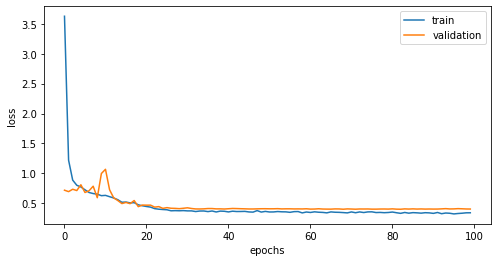

In [16]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

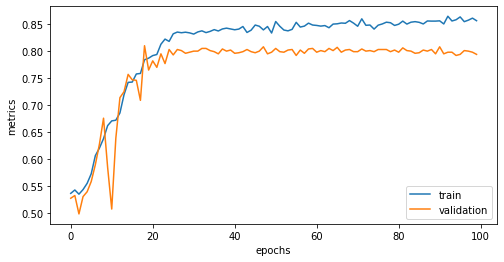

In [17]:
plt.figure(figsize=(8,4))
plt.plot(history.history['binary_accuracy'], label='train')
plt.plot(history.history['val_binary_accuracy'], label='validation')
plt.ylabel('metrics')
plt.xlabel('epochs')
plt.legend(loc='lower right')
plt.show()